In [19]:
import numpy as np
import _pickle as cPickle
import os
import gzip
import matplotlib.pyplot as plt
from tqdm import tqdm


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [71]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    # the derivate of the sigmoid function wrt to its input is simply sigmoid(x)*(1-sigmoid(x))
    tmp = sigmoid(x)
    return tmp * (1 - tmp)

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    # the derivative of the tanh function is 1-tanh²(x)
    tmp = tanh(x)
    return 1 - tmp * tmp

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    # the derivative of the relu function is defined as 1 for x>0 and 0 everywhere else
    grad = np.zeros(x.shape)
    grad[x>0] = 1
    return grad

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        # TODO ################################
        # TODO: implement weight initialization
        # TODO ################################
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(0, init_stddev, (self.input_shape[1], num_units))
        # and this is the bias vector of shape: (num_units)
        self.b = np.random.normal(0, init_stddev, num_units)
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # TODO ################################################
        # TODO: implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        # TODO ################################################
        # you again want to cache the last_input for the bprop
        # implementation below!
        self.last_input = input
        # NOTE: Use numpy dot product
        # h = t(a), a = W * x + b 
        output = np.dot(input, self.W) + self.b
        if self.activation_fun is not None:
            output = self.activation_fun.fprop(output)
            
        return output
            
        #FIXME
#         raise NotImplementedError("You should implement this!")
#         return np.zeros(self.output_size)
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # TODO ################################
        # TODO: implement backward propagation
        # TODO ###############################
        
        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work 
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # NOTE: you should also handle the case where 
        #       activation_fun is None (meaning no activation)
        if self.activation_fun is not None:
            # check in bprop if the dimensions are right!
            output_grad = self.activation_fun.bprop(output_grad)
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        
        # Does this mean that I have to sum up an old value
        # of dW and a new one? But I should already divide 
        # by n here, so I do not just have a sum, but I don't
        # know how many minibatches already happened, so I cannot
        # compute a mean between the old and the new values because
        # I do not know how many samples contributed to the old value
        # I could sum up the values here and divide by the number of 
        # minibatches at the end of each epoch, but doesn't that also 
        # mean that the gradient checking will only work in the first 
        # minibatch? 
        # --> NO ACCUMULATION OF VALUES IMPLEMENTED (YET)
        
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        # NOTE: self.dW is also a numpy dot product
        # This (I think) gives me the right shape, also corresponds
        # to the formula given in the slides when I consider that my
        # shapes are alltransposed compared to the ones in the slides
        self.dW = np.dot(self.last_input.T, output_grad) * (1/n)
        # Through the matrix multiplication, dW already takes the sum 
        # over several samples, I think I need to do the same for db
        self.db = np.sum(output_grad, axis=0) * (1/n)
        # the gradient wrt. the input should be calculated here
        # again, this corresponds to the formula in the slides when
        # the transposed shapes are considered
        grad_input = np.dot(output_grad, self.W.T)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # TODO ####################################
        # TODO: implement gradient of squared loss
        # TODO ####################################
        return Y_pred -Y

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
#         print('Nan before softmax:', np.isnan(input).any())
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # TODO #######################################################
        # TODO: implement gradient of the negative log likelihood loss
        # TODO #######################################################
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(np.exp(x), axis=1))
        #       this gradient computation can be simplified a lot,
        #       you may find a connection to the LinearOutput layer!
        return Y_pred - Y

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable 
        # you should add an epsilon in the log ;)
        eps = 1e-10
        # TODO ####################################
        # calculate negative log likelihood
        # TODO ####################################
#         print(np.isnan(out).any())
#         print(np.log(out+eps))
        loss = np.sum(-1 * np.multiply(np.log(out + eps),Y), axis=1)
        return np.mean(loss)
        

In [103]:
# erst std, dann lr
train_results = test_network(X_train, y_train, X_valid, y_valid,
                                 [200],0.1, 0.4,
                                 0, 'sgd', 128, 15)

... starting training
epoch 0, loss 0.3056, train error 0.0852
epoch 0, validation loss 0.3186, validation error 0.0950
epoch 1, loss 0.2247, train error 0.0627
epoch 1, validation loss 0.2419, validation error 0.0600
epoch 2, loss 0.1808, train error 0.0521
epoch 2, validation loss 0.2031, validation error 0.0650
epoch 3, loss 0.1513, train error 0.0433
epoch 3, validation loss 0.1771, validation error 0.0400
epoch 4, loss 0.1287, train error 0.0360
epoch 4, validation loss 0.1590, validation error 0.0400
epoch 5, loss 0.1099, train error 0.0300
epoch 5, validation loss 0.1447, validation error 0.0400
epoch 6, loss 0.0934, train error 0.0248
epoch 6, validation loss 0.1320, validation error 0.0300
epoch 7, loss 0.0798, train error 0.0206
epoch 7, validation loss 0.1214, validation error 0.0250
epoch 8, loss 0.0687, train error 0.0171
epoch 8, validation loss 0.1129, validation error 0.0250
epoch 9, loss 0.0593, train error 0.0133
epoch 9, validation loss 0.1062, validation error 0.025

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [72]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        # TODO ##########################################
        # TODO: implement forward pass through all layers
        # TODO ##########################################
        Y_pred = X.copy()
        cnt = 0
        for layer in self.layers:
            Y_pred = layer.fprop(Y_pred)
#             print('Nan in forward pass: ',np.isnan(Y_pred).any(), 'Layer: ',cnt)
            cnt+=1

        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        # TODO ##########################################
        # TODO: implement backward pass through all layers
        # TODO ##########################################
        # I need the layer indices in reversed order to know
        # when I reach the "upto" layer
        for ind in range(len(self.layers)-1)[::-1]:
            next_grad = self.layers[ind].bprop(next_grad)
            if ind == upto:
                break    
               
        return next_grad
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size, weight_decay=0):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # TODO #####################################
            # Implement stochastic gradient descent here
            # TODO #####################################
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)
            X_mb = X[b * batch_size: b * batch_size + batch_size] 
            Y_mb = Y[b * batch_size: b * batch_size + batch_size]
            # TODO: then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            # forward pass
            Y_pred = self.predict(X_mb)
            # backpropagation
            grad = self.backpropagate(Y_mb,Y_pred)     
            # layer.params() returns the two parameters, the first
            # element is W, the second b
            # go through all layers
            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()
#                     print('Gradient is nan: ', np.isnan(dW).any(), np.isnan(db).any())
                    layer.W -= learning_rate * dW + weight_decay * W
                    layer.b -= learning_rate * db
#                     layer.dW, layer.db = None, None
                                  
                                  
    
    def gd_epoch(self, X, Y, learning_rate, weight_decay=0):
                                  
        # TODO ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # TODO ##################################################
        
        # if X contains more than 2000 samples, divide the gradient
        # process into several steps
        if X.shape[0] > 2000:
            batch_size = 1024
            num_batches = X.shape[0] // batch_size

            for b in range(num_batches):
                
                # first save the old gradients
                gradients_old = []
                for layer in self.layers:
                    if isinstance(layer, Parameterized):
                        dW_old, db_old = layer.grad_params()
                        gradients_old.append((dW_old, db_old))
                        
                X_mb = X[b * batch_size: b * batch_size + batch_size]
                Y_mb = Y[b * batch_size: b * batch_size + batch_size]
                
                Y_pred = self.predict(X_mb)
                grad = self.backpropagate(Y_mb, Y_pred)
                
                # now we have the new gradients in grad_params()
                layer_cnt = 0
                for layer in self.layers:
                    if isinstance(layer, Parameterized):
                        dW_new, db_new = layer.grad_params()
                        # our gradient should be a combination of the old 
                        # gradient and the new one, weighted by the number
                        # of samples used to compute it 
                        if dW_old is not None:
                            layer.dW = (b-1)/b * gradients_old[layer_cnt][0] + (1/b) * dW_new 
                            layer.db = (b-1)/b * gradients_old[layer_cnt][1] + (1/b) * db_new
                        layer_cnt += 1
        
        else:
            Y_pred = self.predict(X)
            grad = self.backpropagate(Y, Y_pred)
                                  
        # update parameters
        for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()
                    layer.W -= learning_rate * dW + weight_decay * W
                    layer.b -= learning_rate * db  
                    layer.dW, layer.db = None, None
        
    
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True, weight_decay=0):

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        # initialize lists to save the loss and error values
        train_loss_lst, train_err_lst, val_loss_lst, val_err_lst = [], [], [], []
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size, weight_decay)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate, weight_decay)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            # save train loss to list
            train_loss_lst.append(train_loss)
            train_error = self.classification_error(X, Y)
            train_err_lst.append(train_error)
            print('epoch {}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))

            # compute error on validation data
            if y_one_hot:
                Y_val = one_hot(Y_valid)
            else:
                Y_val = Y_valid
            val_loss = self._loss(X_valid, Y_val)
            val_loss_lst.append(val_loss)
            val_error = self.classification_error(X_valid, Y_valid)
            val_err_lst.append(val_error)
            print('epoch {}, validation loss {:.4f}, validation error {:.4f}'.format(e, val_loss, val_error))
            
        return (train_loss_lst, train_err_lst), (val_loss_lst, val_err_lst)
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [5]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [6]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [7]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 1.03e-07
diff scipy 3.60e-08
checking gradient for layer 2
diff scipy 8.08e-08
diff scipy 2.44e-08
checking gradient for layer 3
diff scipy 5.93e-08
diff scipy 8.78e-09


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [8]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [9]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


In [11]:
# use less training samples for testing purposes
X_train = X_train[:10000]
y_train = y_train[:10000]
X_valid = X_valid[:200]
y_valid = y_valid[:200]

Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [12]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
# layers.append(FullyConnectedLayer(
#                 layers[-1],
#                 num_units=100,
#                 init_stddev=0.01,
#                 activation_fun=Activation('relu')
# ))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=50,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_results = nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
         max_epochs=30, batch_size=128, y_one_hot=True, weight_decay=0.0005)
# nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
#          max_epochs=200, batch_size=64, y_one_hot=True, descent_type="gd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0, loss 2.2998, train error 0.8873
epoch 0, validation loss 2.3022, validation error 0.9000
epoch 1, loss 2.2946, train error 0.8873
epoch 1, validation loss 2.2975, validation error 0.9000
epoch 2, loss 1.4179, train error 0.5311
epoch 2, validation loss 1.4115, validation error 0.5100
epoch 3, loss 0.8442, train error 0.3058
epoch 3, validation loss 0.8623, validation error 0.3300
epoch 4, loss 0.5677, train error 0.1644
epoch 4, validation loss 0.5816, validation error 0.1700
epoch 5, loss 0.4735, train error 0.1350
epoch 5, validation loss 0.5186, validation error 0.1300
epoch 6, loss 0.4061, train error 0.1136
epoch 6, validation loss 0.4627, validation error 0.1200
epoch 7, loss 0.3551, train error 0.0984
epoch 7, validation loss 0.4209, validation error 0.1200
epoch 8, loss 0.3157, train error 0.0880
epoch 8, validation loss 0.3830, validation error 0.1200
epoch 9, loss 0.2833, train error 0.0797
epoch 9, validation loss 0.3451, validation error 0.120

In [29]:
# Test several networks and configurations
# Parameters that should be tested: 
# - number of layers -> between 2 and 4
# - number of neurons per layer -> [20,50,100,200,1000] ? 
# - learning rate -> [0.1, 0.05, 0.01, 0.005, 0.001]
# - sgd or gd (different batch_size for sgd)
# - activation functions??? -> i think relu is normally used for this classification
# - initialization of parameters

# network parameters
num_layers = [2,3,4]
num_units_fl = [100,500,1500]
num_units_sl = [50,200,1000]
num_units_tl = [50,200]
std_inits = [0.1,0.05]

# training parameters
training_alg = ['sgd', 'gd']
learning_rates = [0.1,0.01]
weight_decays = [0,0.0001]
batch_sizes = [64,128]

num_epochs = [5,5]

In [36]:
std_init = 0.1
batchsize = 128
weight_decay = 0
learning_rate = 0.1
learning_alg = 'sgd'

num_units_fl = [500,2000]
num_units_sl = [200,1000]
num_units_tl = [200,1000]

num_epochs = 30

In [37]:
results = {'number of units' : [],
           'train results' : []}

t0 = time.time()
# test 3-layer nets
for i in tqdm(range(2)):
    units_f = num_units_fl[i]
    for j in tqdm(range(2)):
        units_s = num_units_sl[j]
        if units_s > units_f:
            break
        print('Layer 1:',units_f, 'Layer 2:',units_s)
        train_results = test_network(X_train, y_train, X_valid, y_valid,
                                     [units_f,units_s], std_init, learning_rate,
                                     weight_decay, learning_alg, batchsize, num_epochs)
        results['number of units'].append([units_f,units_s])
        results['train results'].append([train_results])
        
        
# test 4-layer nets     
for i in tqdm(range(2)):
    units_f = num_units_fl[i]
    for j in tqdm(range(2)):
        units_s = num_units_sl[j]
        if units_s > units_f:
            break
        for units_t in num_units_tl:
            if units_t > units_s:
                 break
            print('Layer 1:',units_f, 'Layer 2:',units_s, 'Layer 3:', units_t)
            train_results = test_network(X_train, y_train, X_valid, y_valid,
                                 [units_f,units_s,units_t], std_init, learning_rate,
                                 weight_decay, learning_alg, batchsize, num_epochs)
            results['number of units'].append([units_f,units_s,units_t])
            results['train results'].append([train_results])
            
t1 = time.time()
print('Time needed:', (t1-t0)/60, 'min')






  0%|          | 0/2 [00:00<?, ?it/s]





  0%|          | 0/2 [00:00<?, ?it/s]

Layer 1: 500 Layer 2: 200
... starting training
epoch 0, loss 0.3553, train error 0.1004
epoch 0, validation loss 0.3273, validation error 0.1100
epoch 1, loss 0.2567, train error 0.0728
epoch 1, validation loss 0.2458, validation error 0.0800
epoch 2, loss 0.2050, train error 0.0561
epoch 2, validation loss 0.2083, validation error 0.0600
epoch 3, loss 0.1702, train error 0.0459
epoch 3, validation loss 0.1850, validation error 0.0450
epoch 4, loss 0.1440, train error 0.0386
epoch 4, validation loss 0.1678, validation error 0.0450
epoch 5, loss 0.1236, train error 0.0322
epoch 5, validation loss 0.1550, validation error 0.0450
epoch 6, loss 0.1069, train error 0.0271
epoch 6, validation loss 0.1439, validation error 0.0450
epoch 7, loss 0.0928, train error 0.0221
epoch 7, validation loss 0.1350, validation error 0.0450
epoch 8, loss 0.0812, train error 0.0198
epoch 8, validation loss 0.1282, validation error 0.0450
epoch 9, loss 0.0713, train error 0.0170
epoch 9, validation loss 0.12







 50%|█████     | 1/2 [01:17<01:17, 77.79s/it]




 50%|█████     | 1/2 [01:17<01:17, 77.81s/it]






  0%|          | 0/2 [00:00<?, ?it/s]

epoch 30, loss 0.0092, train error 0.0001
epoch 30, validation loss 0.0951, validation error 0.0350
Layer 1: 2000 Layer 2: 200
... starting training
epoch 0, loss 0.2945, train error 0.0843
epoch 0, validation loss 0.3214, validation error 0.0950
epoch 1, loss 0.1892, train error 0.0518
epoch 1, validation loss 0.2218, validation error 0.0600
epoch 2, loss 0.1396, train error 0.0382
epoch 2, validation loss 0.1791, validation error 0.0500
epoch 3, loss 0.1068, train error 0.0286
epoch 3, validation loss 0.1531, validation error 0.0400
epoch 4, loss 0.0832, train error 0.0209
epoch 4, validation loss 0.1335, validation error 0.0400
epoch 5, loss 0.0662, train error 0.0150
epoch 5, validation loss 0.1213, validation error 0.0300
epoch 6, loss 0.0532, train error 0.0112
epoch 6, validation loss 0.1118, validation error 0.0300
epoch 7, loss 0.0424, train error 0.0073
epoch 7, validation loss 0.1039, validation error 0.0300
epoch 8, loss 0.0344, train error 0.0055
epoch 8, validation loss 0








 50%|█████     | 1/2 [04:16<04:16, 256.93s/it]

epoch 30, loss 0.0036, train error 0.0000
epoch 30, validation loss 0.0832, validation error 0.0150
Layer 1: 2000 Layer 2: 1000
... starting training
epoch 0, loss 0.1987, train error 0.0581
epoch 0, validation loss 0.2611, validation error 0.0750
epoch 1, loss 0.1095, train error 0.0270
epoch 1, validation loss 0.2002, validation error 0.0550
epoch 2, loss 0.0681, train error 0.0128
epoch 2, validation loss 0.1700, validation error 0.0500
epoch 3, loss 0.0452, train error 0.0063
epoch 3, validation loss 0.1557, validation error 0.0300
epoch 4, loss 0.0317, train error 0.0029
epoch 4, validation loss 0.1474, validation error 0.0300
epoch 5, loss 0.0236, train error 0.0014
epoch 5, validation loss 0.1407, validation error 0.0300
epoch 6, loss 0.0183, train error 0.0005
epoch 6, validation loss 0.1346, validation error 0.0300
epoch 7, loss 0.0148, train error 0.0002
epoch 7, validation loss 0.1294, validation error 0.0300
epoch 8, loss 0.0124, train error 0.0001
epoch 8, validation loss 








100%|██████████| 2/2 [12:06<00:00, 320.74s/it]











100%|██████████| 2/2 [13:24<00:00, 272.44s/it]










  0%|          | 0/2 [00:00<?, ?it/s]






  0%|          | 0/2 [00:00<?, ?it/s]

epoch 30, loss 0.0024, train error 0.0000
epoch 30, validation loss 0.0942, validation error 0.0300
Layer 1: 500 Layer 2: 200 Layer 3: 200
... starting training
epoch 0, loss 0.3343, train error 0.0988
epoch 0, validation loss 0.3206, validation error 0.1000
epoch 1, loss 0.2214, train error 0.0652
epoch 1, validation loss 0.2193, validation error 0.0800
epoch 2, loss 0.1679, train error 0.0483
epoch 2, validation loss 0.1751, validation error 0.0550
epoch 3, loss 0.1350, train error 0.0388
epoch 3, validation loss 0.1544, validation error 0.0550
epoch 4, loss 0.1110, train error 0.0323
epoch 4, validation loss 0.1468, validation error 0.0450
epoch 5, loss 0.0903, train error 0.0264
epoch 5, validation loss 0.1419, validation error 0.0450
epoch 6, loss 0.0716, train error 0.0192
epoch 6, validation loss 0.1347, validation error 0.0450
epoch 7, loss 0.0563, train error 0.0144
epoch 7, validation loss 0.1288, validation error 0.0350
epoch 8, loss 0.0442, train error 0.0097
epoch 8, valid








 50%|█████     | 1/2 [01:40<01:40, 100.42s/it]





 50%|█████     | 1/2 [01:40<01:40, 100.46s/it]







  0%|          | 0/2 [00:00<?, ?it/s]

epoch 30, loss 0.0032, train error 0.0001
epoch 30, validation loss 0.1288, validation error 0.0450
Layer 1: 2000 Layer 2: 200 Layer 3: 200
... starting training
epoch 0, loss 0.3437, train error 0.1044
epoch 0, validation loss 0.2961, validation error 0.0950
epoch 1, loss 0.2056, train error 0.0596
epoch 1, validation loss 0.2231, validation error 0.0700
epoch 2, loss 0.1508, train error 0.0436
epoch 2, validation loss 0.1912, validation error 0.0500
epoch 3, loss 0.1111, train error 0.0316
epoch 3, validation loss 0.1625, validation error 0.0550
epoch 4, loss 0.0877, train error 0.0238
epoch 4, validation loss 0.1409, validation error 0.0500
epoch 5, loss 0.0692, train error 0.0176
epoch 5, validation loss 0.1262, validation error 0.0450
epoch 6, loss 0.0528, train error 0.0125
epoch 6, validation loss 0.1179, validation error 0.0350
epoch 7, loss 0.0405, train error 0.0086
epoch 7, validation loss 0.1131, validation error 0.0400
epoch 8, loss 0.0302, train error 0.0057
epoch 8, vali









 50%|█████     | 1/2 [05:39<05:39, 339.20s/it]

epoch 30, loss 0.0017, train error 0.0000
epoch 30, validation loss 0.1187, validation error 0.0400
Layer 1: 2000 Layer 2: 1000 Layer 3: 200
... starting training
epoch 0, loss 0.2653, train error 0.0787
epoch 0, validation loss 0.3355, validation error 0.1200
epoch 1, loss 0.1528, train error 0.0446
epoch 1, validation loss 0.2385, validation error 0.0800
epoch 2, loss 0.0912, train error 0.0243
epoch 2, validation loss 0.1898, validation error 0.0650
epoch 3, loss 0.0594, train error 0.0139
epoch 3, validation loss 0.1676, validation error 0.0550
epoch 4, loss 0.0350, train error 0.0063
epoch 4, validation loss 0.1547, validation error 0.0600
epoch 5, loss 0.0214, train error 0.0021
epoch 5, validation loss 0.1455, validation error 0.0500
epoch 6, loss 0.0138, train error 0.0004
epoch 6, validation loss 0.1420, validation error 0.0500
epoch 7, loss 0.0100, train error 0.0001
epoch 7, validation loss 0.1424, validation error 0.0450
epoch 8, loss 0.0078, train error 0.0001
epoch 8, val

/home/rabea/anaconda3/envs/dllab/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in maximum
/home/rabea/anaconda3/envs/dllab/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rabea/anaconda3/envs/dllab/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


epoch 0, loss nan, train error 0.8999
epoch 0, validation loss nan, validation error 0.9050
epoch 1, loss nan, train error 0.8999
epoch 1, validation loss nan, validation error 0.9050
epoch 2, loss nan, train error 0.8999
epoch 2, validation loss nan, validation error 0.9050
epoch 3, loss nan, train error 0.8999
epoch 3, validation loss nan, validation error 0.9050
epoch 4, loss nan, train error 0.8999
epoch 4, validation loss nan, validation error 0.9050
epoch 5, loss nan, train error 0.8999
epoch 5, validation loss nan, validation error 0.9050
epoch 6, loss nan, train error 0.8999
epoch 6, validation loss nan, validation error 0.9050
epoch 7, loss nan, train error 0.8999
epoch 7, validation loss nan, validation error 0.9050
epoch 8, loss nan, train error 0.8999
epoch 8, validation loss nan, validation error 0.9050
epoch 9, loss nan, train error 0.8999
epoch 9, validation loss nan, validation error 0.9050
epoch 10, loss nan, train error 0.8999
epoch 10, validation loss nan, validation









100%|██████████| 2/2 [22:54<00:00, 547.98s/it]













100%|██████████| 2/2 [24:34<00:00, 482.64s/it]







epoch 30, loss nan, train error 0.8999
epoch 30, validation loss nan, validation error 0.9050
Time needed: 37.98762460549673 min


In [47]:
train_results = test_network(X_train, y_train, X_valid, y_valid,
                                 [2000,1000,1000],0.1, 0.1,
                                 0, 'sgd', 128, 2)

... starting training


/home/rabea/anaconda3/envs/dllab/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in maximum
/home/rabea/anaconda3/envs/dllab/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


epoch 0, loss nan, train error 0.8999
epoch 0, validation loss nan, validation error 0.9050
epoch 1, loss nan, train error 0.8999
epoch 1, validation loss nan, validation error 0.9050
epoch 2, loss nan, train error 0.8999
epoch 2, validation loss nan, validation error 0.9050


In [33]:
def test_network(X, y, X_val, y_val, num_units, init_std, lr, wd, alg, bs, num_epochs):
    
    input_shape = (None, 28*28)
    num_layers = len(num_units)
    # create network
    layers = [InputLayer(input_shape)]
    # add layers 
    for i in range(num_layers):
        layers.append(FullyConnectedLayer(
                            layers[-1],
                            num_units=num_units[i],
                            init_stddev=init_std,
                            activation_fun=Activation('relu')))
    # append last layer with 10 units
    layers.append(FullyConnectedLayer(
        layers[-1],
        num_units=10,
        init_stddev=init_std,
        activation_fun=None))
    # Output layer
    layers.append(SoftmaxOutput(layers[-1]))
    nn = NeuralNetwork(layers)
    
    # train network
    train_results = nn.train(X, y,
                             X_valid, y_valid,
                             learning_rate=lr,
                             weight_decay=wd,
                             descent_type=alg,
                             max_epochs=num_epochs,
                             batch_size=bs,
                             y_one_hot=True)
    
    return train_results

In [32]:
# exhaustive testing over night
input_shape = (None,28*28)
results = {'units first layer' : [],
           'units second layer' : [],
           'units third layer' : [],
           'std init' : [],
           'training algorithm' : [],
           'learning rate' : [],
           'weight decay' : [],
           'batchsize' : [],
           'train results' : []}

t0 = time.time()
for i in tqdm(range(3)):
    layer_num = num_layers[i]
    # network parameters
    if layer_num == 2:
        for j in tqdm(range(len(num_units_fl))):
            units_f = num_units_fl[j]
            for std in std_inits:
                # training parameters
                for lr in learning_rates:
                    for wd in weight_decays:
                        for alg in training_alg:
                            if alg == 'gd':
                                bs = 0
                                print('2 Layers, num units: ',units_f, ',std: ',std,',lr: ',lr,'alg: ',alg,'wd: ',wd,'bs: ',bs)
                                train_results = test_network(
                                    X_train, y_train,
                                    X_valid, y_valid,
                                    num_units=[units_f],
                                    init_std=std,
                                    lr=lr,
                                    wd=wd,
                                    alg=alg,
                                    num_epochs=num_epochs[1],
                                    bs=128)
                                # save train results
                                results['units first layer'].append(units_f)
                                results['units second layer'].append(0)
                                results['units third layer'].append(0)
                                results['std init'].append(std)
                                results['training algorithm'].append('gd')
                                results['learning rate'].append(lr)
                                results['weight decay'].append(wd)
                                results['batchsize'].append(0)
                                half = len(train_results[0][0]) // 2
                                results['train results'].append([
                                    (train_results[0][0][half],train_results[0][0][-1]),
                                    (train_results[0][1][half],train_results[0][1][-1]),
                                    (train_results[1][0][half],train_results[1][0][-1]),
                                    (train_results[1][1][half],train_results[1][1][-1])])
                            else:
                                for bs in batch_sizes:
                                    print('2 Layers, num units: ',units_f, ',std: ',std,',lr: ',lr,'alg: ',alg,'wd: ',wd,'bs: ',bs)
                                    train_results = test_network(
                                        X_train, y_train,
                                        X_valid, y_valid,
                                        num_units=[units_f],
                                        init_std=std,
                                        lr=lr,
                                        wd=wd,
                                        alg=alg,
                                        num_epochs=num_epochs[1],
                                        bs=bs)
                                    # save train results
                                    results['units first layer'].append(units_f)
                                    results['units second layer'].append(0)
                                    results['units third layer'].append(0)
                                    results['std init'].append(std)
                                    results['training algorithm'].append('sgd')
                                    results['learning rate'].append(lr)
                                    results['weight decay'].append(wd)
                                    results['batchsize'].append(bs)
                                    half = len(train_results[0][0]) // 2
                                    results['train results'].append([
                                        (train_results[0][0][half],train_results[0][0][-1]),
                                        (train_results[0][1][half],train_results[0][1][-1]),
                                        (train_results[1][0][half],train_results[1][0][-1]),
                                        (train_results[1][1][half],train_results[1][1][-1])])

    if layer_num == 3:
        for j in tqdm(range(len(num_units_fl))):
            units_f = num_units_fl[j]
            for units_s in num_units_sl:
                if units_s > units_f:
                    break
                else:
                    for std in std_inits: 
                        # training parameters
                        for lr in learning_rates:
                            for wd in weight_decays:
                                for alg in training_alg:
                                    if alg == 'gd':
                                        bs = 0
                                        print('2 Layers, num units:',units_f, ',std:',std,',lr:',lr,'alg:',alg,'wd:',wd,'bs:',bs)
                                        train_results = test_network(
                                            X_train, y_train,
                                            X_valid, y_valid,
                                            num_units=[units_f],
                                            init_std=std,
                                            lr=lr,
                                            wd=wd,
                                            alg=alg,
                                            num_epochs=num_epochs[1],
                                            bs=128)
                                        # save train results
                                        results['units first layer'].append(units_f)
                                        results['units second layer'].append(0)
                                        results['units third layer'].append(0)
                                        results['std init'].append(std)
                                        results['training algorithm'].append('gd')
                                        results['learning rate'].append(lr)
                                        results['weight decay'].append(wd)
                                        results['batchsize'].append(0)
                                        half = len(train_results[0][0]) // 2
                                        results['train results'].append([
                                            (train_results[0][0][half],train_results[0][0][-1]),
                                            (train_results[0][1][half],train_results[0][1][-1]),
                                            (train_results[1][0][half],train_results[1][0][-1]),
                                            (train_results[1][1][half],train_results[1][1][-1])])
                                    else:
                                        for bs in batch_sizes:
                                            print('2 Layers, num units:',units_f, ',std:',std,',lr:',lr,'alg:',alg,'wd:',wd,'bs:',bs)
                                            train_results = test_network(
                                                X_train, y_train,
                                                X_valid, y_valid,
                                                num_units=[units_f],
                                                init_std=std,
                                                lr=lr,
                                                wd=wd,
                                                alg=alg,
                                                num_epochs=num_epochs[1],
                                                bs=bs)
                                            # save train results
                                            results['units first layer'].append(units_f)
                                            results['units second layer'].append(0)
                                            results['units third layer'].append(0)
                                            results['std init'].append(std)
                                            results['training algorithm'].append('sgd')
                                            results['learning rate'].append(lr)
                                            results['weight decay'].append(wd)
                                            results['batchsize'].append(bs)
                                            half = len(train_results[0][0]) // 2
                                            results['train results'].append([
                                                (train_results[0][0][half],train_results[0][0][-1]),
                                                (train_results[0][1][half],train_results[0][1][-1]),
                                                (train_results[1][0][half],train_results[1][0][-1]),
                                                (train_results[1][1][half],train_results[1][1][-1])])

                    
    if layer_num == 4:
        for j in tqdm(range(len(num_units_fl))):
            units_f = num_units_fl[j]
            for units_s in num_units_sl:
                if units_s > units_f:
                    break
                else:
                    for units_t in num_units_tl:
                        if units_t > units_f or units_t > units_s:
                            break
                        else:
                            for std in std_inits: 
                                # training parameters
                                for lr in learning_rates:
                                    for wd in weight_decays:
                                        for alg in training_alg:
                                            if alg == 'gd':
                                                bs = 0
                                                print('2 Layers, num units:',units_f, ',std:',std,',lr:',lr,'alg:',alg,'wd:',wd,'bs:',bs)
                                                train_results = test_network(
                                                    X_train, y_train,
                                                    X_valid, y_valid,
                                                    num_units=[units_f],
                                                    init_std=std,
                                                    lr=lr,
                                                    wd=wd,
                                                    alg=alg,
                                                    num_epochs=num_epochs[1],
                                                    bs=128)
                                                # save train results
                                                results['units first layer'].append(units_f)
                                                results['units second layer'].append(0)
                                                results['units third layer'].append(0)
                                                results['std init'].append(std)
                                                results['training algorithm'].append('gd')
                                                results['learning rate'].append(lr)
                                                results['weight decay'].append(wd)
                                                results['batchsize'].append(0)
                                                half = len(train_results[0][0]) // 2
                                                results['train results'].append([
                                                    (train_results[0][0][half],train_results[0][0][-1]),
                                                    (train_results[0][1][half],train_results[0][1][-1]),
                                                    (train_results[1][0][half],train_results[1][0][-1]),
                                                    (train_results[1][1][half],train_results[1][1][-1])])
                                            else:
                                                for bs in batch_sizes:
                                                    print('2 Layers, num units:',units_f, ',std:',std,',lr:',lr,'alg:',alg,'wd:',wd,'bs:',bs)
                                                    train_results = test_network(
                                                        X_train, y_train,
                                                        X_valid, y_valid,
                                                        num_units=[units_f],
                                                        init_std=std,
                                                        lr=lr,
                                                        wd=wd,
                                                        alg=alg,
                                                        num_epochs=num_epochs[1],
                                                        bs=bs)
                                                    # save train results
                                                    results['units first layer'].append(units_f)
                                                    results['units second layer'].append(0)
                                                    results['units third layer'].append(0)
                                                    results['std init'].append(std)
                                                    results['training algorithm'].append('sgd')
                                                    results['learning rate'].append(lr)
                                                    results['weight decay'].append(wd)
                                                    results['batchsize'].append(bs)
                                                    half = len(train_results[0][0]) // 2
                                                    results['train results'].append([
                                                        (train_results[0][0][half],train_results[0][0][-1]),
                                                        (train_results[0][1][half],train_results[0][1][-1]),
                                                        (train_results[1][0][half],train_results[1][0][-1]),
                                                        (train_results[1][1][half],train_results[1][1][-1])])

t1 = time.time()
print('Time needed: ', (t1-t0)/60, 'min')






  0%|          | 0/3 [00:00<?, ?it/s]





  0%|          | 0/3 [00:00<?, ?it/s]

2 Layers, num units:  100 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  64
... starting training
epoch 0, loss 0.4420, train error 0.1239
epoch 0, validation loss 0.4677, validation error 0.1300
epoch 1, loss 0.3368, train error 0.0959
epoch 1, validation loss 0.3763, validation error 0.1150
epoch 2, loss 0.2871, train error 0.0806
epoch 2, validation loss 0.3293, validation error 0.1100
epoch 3, loss 0.2552, train error 0.0709
epoch 3, validation loss 0.2983, validation error 0.1100
epoch 4, loss 0.2297, train error 0.0641
epoch 4, validation loss 0.2736, validation error 0.0950
epoch 5, loss 0.2092, train error 0.0586
epoch 5, validation loss 0.2532, validation error 0.0850
2 Layers, num units:  100 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.5745, train error 0.1576
epoch 0, validation loss 0.5733, validation error 0.1650
epoch 1, loss 0.4205, train error 0.1195
epoch 1, validation loss 0.4287, validation error 0.1450
epoch 2, loss 0.3597, train

epoch 0, loss 0.4804, train error 0.1331
epoch 0, validation loss 0.4522, validation error 0.1200
epoch 1, loss 0.3583, train error 0.1003
epoch 1, validation loss 0.3524, validation error 0.0950
epoch 2, loss 0.3060, train error 0.0858
epoch 2, validation loss 0.3130, validation error 0.0950
epoch 3, loss 0.2729, train error 0.0752
epoch 3, validation loss 0.2875, validation error 0.0950
epoch 4, loss 0.2480, train error 0.0700
epoch 4, validation loss 0.2698, validation error 0.0900
epoch 5, loss 0.2270, train error 0.0656
epoch 5, validation loss 0.2558, validation error 0.0900
2 Layers, num units:  100 ,std:  0.05 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.6855, train error 0.1684
epoch 0, validation loss 0.6849, validation error 0.1950
epoch 1, loss 0.4545, train error 0.1197
epoch 1, validation loss 0.4551, validation error 0.1500
epoch 2, loss 0.3815, train error 0.1028
epoch 2, validation loss 0.3886, validation error 0.1200
epoch 3, loss 0.3420, 







 33%|███▎      | 1/3 [01:36<03:12, 96.22s/it]

epoch 5, loss 2.3026, train error 0.8786
epoch 5, validation loss 2.2949, validation error 0.9000
2 Layers, num units:  500 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  64
... starting training
epoch 0, loss 0.3266, train error 0.0914
epoch 0, validation loss 0.3331, validation error 0.1000
epoch 1, loss 0.2421, train error 0.0663
epoch 1, validation loss 0.2681, validation error 0.0750
epoch 2, loss 0.1988, train error 0.0532
epoch 2, validation loss 0.2337, validation error 0.0750
epoch 3, loss 0.1693, train error 0.0460
epoch 3, validation loss 0.2086, validation error 0.0700
epoch 4, loss 0.1467, train error 0.0405
epoch 4, validation loss 0.1892, validation error 0.0600
epoch 5, loss 0.1285, train error 0.0334
epoch 5, validation loss 0.1740, validation error 0.0500
2 Layers, num units:  500 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.4160, train error 0.1185
epoch 0, validation loss 0.4275, validation error 0.1250
epoch 1, loss 0.3188, train

epoch 5, loss 2.6497, train error 0.8902
epoch 5, validation loss 2.6312, validation error 0.9100
2 Layers, num units:  500 ,std:  0.05 ,lr:  0.1 alg:  sgd wd:  0 bs:  64
... starting training
epoch 0, loss 0.4005, train error 0.1106
epoch 0, validation loss 0.3907, validation error 0.1050
epoch 1, loss 0.3064, train error 0.0837
epoch 1, validation loss 0.3119, validation error 0.0900
epoch 2, loss 0.2591, train error 0.0713
epoch 2, validation loss 0.2712, validation error 0.0800
epoch 3, loss 0.2266, train error 0.0629
epoch 3, validation loss 0.2424, validation error 0.0700
epoch 4, loss 0.2017, train error 0.0555
epoch 4, validation loss 0.2206, validation error 0.0650
epoch 5, loss 0.1813, train error 0.0507
epoch 5, validation loss 0.2025, validation error 0.0700
2 Layers, num units:  500 ,std:  0.05 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.5049, train error 0.1270
epoch 0, validation loss 0.4973, validation error 0.1300
epoch 1, loss 0.3790, tra







 67%|██████▋   | 2/3 [06:16<02:31, 151.58s/it]

epoch 5, loss 2.3312, train error 0.8976
epoch 5, validation loss 2.3205, validation error 0.8950
2 Layers, num units:  1500 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  64
... starting training
epoch 0, loss 0.2465, train error 0.0697
epoch 0, validation loss 0.3016, validation error 0.1000
epoch 1, loss 0.1625, train error 0.0430
epoch 1, validation loss 0.2298, validation error 0.0900
epoch 2, loss 0.1220, train error 0.0297
epoch 2, validation loss 0.1924, validation error 0.0650
epoch 3, loss 0.0976, train error 0.0235
epoch 3, validation loss 0.1715, validation error 0.0600
epoch 4, loss 0.0809, train error 0.0178
epoch 4, validation loss 0.1571, validation error 0.0450
epoch 5, loss 0.0681, train error 0.0146
epoch 5, validation loss 0.1463, validation error 0.0400
2 Layers, num units:  1500 ,std:  0.1 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.3248, train error 0.0962
epoch 0, validation loss 0.3490, validation error 0.1200
epoch 1, loss 0.2353, tra

epoch 5, loss 2.7189, train error 0.8327
epoch 5, validation loss 2.5577, validation error 0.8350
2 Layers, num units:  1500 ,std:  0.05 ,lr:  0.1 alg:  sgd wd:  0 bs:  64
... starting training
epoch 0, loss 0.3312, train error 0.0915
epoch 0, validation loss 0.3415, validation error 0.0950
epoch 1, loss 0.2497, train error 0.0685
epoch 1, validation loss 0.2721, validation error 0.0700
epoch 2, loss 0.2074, train error 0.0568
epoch 2, validation loss 0.2349, validation error 0.0550
epoch 3, loss 0.1781, train error 0.0485
epoch 3, validation loss 0.2080, validation error 0.0550
epoch 4, loss 0.1553, train error 0.0416
epoch 4, validation loss 0.1875, validation error 0.0550
epoch 5, loss 0.1368, train error 0.0359
epoch 5, validation loss 0.1714, validation error 0.0500
2 Layers, num units:  1500 ,std:  0.05 ,lr:  0.1 alg:  sgd wd:  0 bs:  128
... starting training
epoch 0, loss 0.3994, train error 0.1040
epoch 0, validation loss 0.4117, validation error 0.1150
epoch 1, loss 0.3095, t







100%|██████████| 3/3 [18:49<00:00, 331.78s/it]










 33%|███▎      | 1/3 [18:49<37:38, 1129.24s/it]





  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5, loss 2.2301, train error 0.8005
epoch 5, validation loss 2.1775, validation error 0.7300
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2661, train error 0.0758
epoch 0, validation loss 0.2597, validation error 0.0750
epoch 1, loss 0.1820, train error 0.0530
epoch 1, validation loss 0.1881, validation error 0.0550
epoch 2, loss 0.1396, train error 0.0400
epoch 2, validation loss 0.1573, validation error 0.0600
epoch 3, loss 0.1117, train error 0.0309
epoch 3, validation loss 0.1389, validation error 0.0450
epoch 4, loss 0.0911, train error 0.0247
epoch 4, validation loss 0.1265, validation error 0.0450
epoch 5, loss 0.0755, train error 0.0195
epoch 5, validation loss 0.1170, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3112, train error 0.0888
epoch 0, validation loss 0.4026, validation error 0.1350
epoch 1, loss 0.2241, train error 0.0

epoch 0, loss 0.3342, train error 0.0909
epoch 0, validation loss 0.3369, validation error 0.0900
epoch 1, loss 0.2496, train error 0.0680
epoch 1, validation loss 0.2628, validation error 0.0600
epoch 2, loss 0.2062, train error 0.0558
epoch 2, validation loss 0.2240, validation error 0.0550
epoch 3, loss 0.1764, train error 0.0466
epoch 3, validation loss 0.1972, validation error 0.0550
epoch 4, loss 0.1536, train error 0.0399
epoch 4, validation loss 0.1770, validation error 0.0400
epoch 5, loss 0.1352, train error 0.0363
epoch 5, validation loss 0.1615, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3933, train error 0.1018
epoch 0, validation loss 0.3813, validation error 0.0850
epoch 1, loss 0.3076, train error 0.0822
epoch 1, validation loss 0.3052, validation error 0.0750
epoch 2, loss 0.2660, train error 0.0720
epoch 2, validation loss 0.2705, validation error 0.0700
epoch 3, loss 0.2382, train

epoch 1, loss 0.1651, train error 0.0468
epoch 1, validation loss 0.2266, validation error 0.0850
epoch 2, loss 0.1287, train error 0.0336
epoch 2, validation loss 0.1939, validation error 0.0650
epoch 3, loss 0.1054, train error 0.0272
epoch 3, validation loss 0.1757, validation error 0.0550
epoch 4, loss 0.0879, train error 0.0228
epoch 4, validation loss 0.1634, validation error 0.0500
epoch 5, loss 0.0739, train error 0.0177
epoch 5, validation loss 0.1534, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3098, train error 0.0927
epoch 0, validation loss 0.3239, validation error 0.1100
epoch 1, loss 0.2293, train error 0.0672
epoch 1, validation loss 0.2517, validation error 0.0950
epoch 2, loss 0.1865, train error 0.0526
epoch 2, validation loss 0.2187, validation error 0.0750
epoch 3, loss 0.1583, train error 0.0432
epoch 3, validation loss 0.1983, validation error 0.0750
epoch 4, loss 0.1374, train 

epoch 2, loss 0.2071, train error 0.0564
epoch 2, validation loss 0.2308, validation error 0.0650
epoch 3, loss 0.1782, train error 0.0469
epoch 3, validation loss 0.2056, validation error 0.0650
epoch 4, loss 0.1559, train error 0.0403
epoch 4, validation loss 0.1862, validation error 0.0650
epoch 5, loss 0.1378, train error 0.0356
epoch 5, validation loss 0.1707, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3953, train error 0.1042
epoch 0, validation loss 0.3966, validation error 0.0900
epoch 1, loss 0.3071, train error 0.0812
epoch 1, validation loss 0.3098, validation error 0.0900
epoch 2, loss 0.2647, train error 0.0712
epoch 2, validation loss 0.2707, validation error 0.0850
epoch 3, loss 0.2364, train error 0.0637
epoch 3, validation loss 0.2458, validation error 0.0700
epoch 4, loss 0.2149, train error 0.0575
epoch 4, validation loss 0.2273, validation error 0.0700
epoch 5, loss 0.1973, train

epoch 3, loss 0.1036, train error 0.0276
epoch 3, validation loss 0.1336, validation error 0.0400
epoch 4, loss 0.0864, train error 0.0219
epoch 4, validation loss 0.1222, validation error 0.0400
epoch 5, loss 0.0728, train error 0.0161
epoch 5, validation loss 0.1143, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3194, train error 0.0923
epoch 0, validation loss 0.3351, validation error 0.0950
epoch 1, loss 0.2361, train error 0.0673
epoch 1, validation loss 0.2604, validation error 0.0800
epoch 2, loss 0.1939, train error 0.0557
epoch 2, validation loss 0.2243, validation error 0.0650
epoch 3, loss 0.1659, train error 0.0459
epoch 3, validation loss 0.2026, validation error 0.0550
epoch 4, loss 0.1447, train error 0.0395
epoch 4, validation loss 0.1874, validation error 0.0500
epoch 5, loss 0.1274, train error 0.0338
epoch 5, validation loss 0.1764, validation error 0.0450
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1514, train error 0.0397
epoch 4, validation loss 0.1904, validation error 0.0550
epoch 5, loss 0.1333, train error 0.0351
epoch 5, validation loss 0.1749, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3956, train error 0.1026
epoch 0, validation loss 0.3880, validation error 0.0950
epoch 1, loss 0.3068, train error 0.0806
epoch 1, validation loss 0.3106, validation error 0.0750
epoch 2, loss 0.2643, train error 0.0705
epoch 2, validation loss 0.2750, validation error 0.0750
epoch 3, loss 0.2361, train error 0.0631
epoch 3, validation loss 0.2510, validation error 0.0650
epoch 4, loss 0.2147, train error 0.0583
epoch 4, validation loss 0.2328, validation error 0.0550
epoch 5, loss 0.1973, train error 0.0541
epoch 5, validation loss 0.2180, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1780, train error 0.8







 33%|███▎      | 1/3 [37:41<1:15:23, 2261.92s/it]

epoch 5, loss 2.1663, train error 0.7980
epoch 5, validation loss 2.1194, validation error 0.7750
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2597, train error 0.0747
epoch 0, validation loss 0.2914, validation error 0.1000
epoch 1, loss 0.1764, train error 0.0499
epoch 1, validation loss 0.2247, validation error 0.0800
epoch 2, loss 0.1355, train error 0.0392
epoch 2, validation loss 0.1922, validation error 0.0750
epoch 3, loss 0.1078, train error 0.0292
epoch 3, validation loss 0.1714, validation error 0.0700
epoch 4, loss 0.0875, train error 0.0223
epoch 4, validation loss 0.1570, validation error 0.0650
epoch 5, loss 0.0727, train error 0.0171
epoch 5, validation loss 0.1479, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3150, train error 0.0904
epoch 0, validation loss 0.3134, validation error 0.0900
epoch 1, loss 0.2303, train error 0.0

epoch 0, loss 0.3365, train error 0.0909
epoch 0, validation loss 0.3535, validation error 0.1150
epoch 1, loss 0.2529, train error 0.0685
epoch 1, validation loss 0.2758, validation error 0.0700
epoch 2, loss 0.2088, train error 0.0567
epoch 2, validation loss 0.2350, validation error 0.0650
epoch 3, loss 0.1787, train error 0.0476
epoch 3, validation loss 0.2072, validation error 0.0650
epoch 4, loss 0.1556, train error 0.0412
epoch 4, validation loss 0.1862, validation error 0.0600
epoch 5, loss 0.1369, train error 0.0360
epoch 5, validation loss 0.1700, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3947, train error 0.1004
epoch 0, validation loss 0.3931, validation error 0.1100
epoch 1, loss 0.3059, train error 0.0791
epoch 1, validation loss 0.3142, validation error 0.0800
epoch 2, loss 0.2630, train error 0.0686
epoch 2, validation loss 0.2779, validation error 0.0750
epoch 3, loss 0.2346, train

epoch 1, loss 0.1689, train error 0.0452
epoch 1, validation loss 0.2114, validation error 0.0750
epoch 2, loss 0.1284, train error 0.0325
epoch 2, validation loss 0.1705, validation error 0.0550
epoch 3, loss 0.1028, train error 0.0256
epoch 3, validation loss 0.1467, validation error 0.0450
epoch 4, loss 0.0847, train error 0.0196
epoch 4, validation loss 0.1308, validation error 0.0400
epoch 5, loss 0.0709, train error 0.0154
epoch 5, validation loss 0.1194, validation error 0.0350
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3099, train error 0.0924
epoch 0, validation loss 0.3299, validation error 0.0900
epoch 1, loss 0.2310, train error 0.0664
epoch 1, validation loss 0.2614, validation error 0.0900
epoch 2, loss 0.1873, train error 0.0528
epoch 2, validation loss 0.2258, validation error 0.0750
epoch 3, loss 0.1577, train error 0.0435
epoch 3, validation loss 0.2023, validation error 0.0550
epoch 4, loss 0.1359, train 

epoch 2, loss 0.2043, train error 0.0549
epoch 2, validation loss 0.2387, validation error 0.0550
epoch 3, loss 0.1753, train error 0.0480
epoch 3, validation loss 0.2114, validation error 0.0500
epoch 4, loss 0.1531, train error 0.0406
epoch 4, validation loss 0.1904, validation error 0.0500
epoch 5, loss 0.1352, train error 0.0359
epoch 5, validation loss 0.1738, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3949, train error 0.1032
epoch 0, validation loss 0.4069, validation error 0.1100
epoch 1, loss 0.3082, train error 0.0825
epoch 1, validation loss 0.3237, validation error 0.0800
epoch 2, loss 0.2658, train error 0.0716
epoch 2, validation loss 0.2848, validation error 0.0800
epoch 3, loss 0.2372, train error 0.0639
epoch 3, validation loss 0.2592, validation error 0.0700
epoch 4, loss 0.2153, train error 0.0581
epoch 4, validation loss 0.2399, validation error 0.0700
epoch 5, loss 0.1974, train

epoch 3, loss 0.1042, train error 0.0272
epoch 3, validation loss 0.1398, validation error 0.0300
epoch 4, loss 0.0852, train error 0.0217
epoch 4, validation loss 0.1276, validation error 0.0250
epoch 5, loss 0.0706, train error 0.0157
epoch 5, validation loss 0.1183, validation error 0.0250
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3141, train error 0.0904
epoch 0, validation loss 0.3694, validation error 0.1400
epoch 1, loss 0.2308, train error 0.0668
epoch 1, validation loss 0.2994, validation error 0.1200
epoch 2, loss 0.1885, train error 0.0540
epoch 2, validation loss 0.2661, validation error 0.1050
epoch 3, loss 0.1608, train error 0.0446
epoch 3, validation loss 0.2471, validation error 0.1050
epoch 4, loss 0.1401, train error 0.0381
epoch 4, validation loss 0.2340, validation error 0.0950
epoch 5, loss 0.1236, train error 0.0327
epoch 5, validation loss 0.2242, validation error 0.0900
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1535, train error 0.0391
epoch 4, validation loss 0.1868, validation error 0.0650
epoch 5, loss 0.1352, train error 0.0343
epoch 5, validation loss 0.1724, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.4006, train error 0.1055
epoch 0, validation loss 0.4085, validation error 0.1150
epoch 1, loss 0.3110, train error 0.0829
epoch 1, validation loss 0.3287, validation error 0.1050
epoch 2, loss 0.2683, train error 0.0723
epoch 2, validation loss 0.2925, validation error 0.1000
epoch 3, loss 0.2399, train error 0.0650
epoch 3, validation loss 0.2687, validation error 0.0900
epoch 4, loss 0.2184, train error 0.0588
epoch 4, validation loss 0.2508, validation error 0.0750
epoch 5, loss 0.2008, train error 0.0530
epoch 5, validation loss 0.2362, validation error 0.0700
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1758, train error 0.7







 67%|██████▋   | 2/3 [1:15:23<37:41, 2261.82s/it]

epoch 5, loss 2.1371, train error 0.7553
epoch 5, validation loss 2.2146, validation error 0.8250
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2910, train error 0.0884
epoch 0, validation loss 0.3786, validation error 0.1050
epoch 1, loss 0.1770, train error 0.0505
epoch 1, validation loss 0.2531, validation error 0.1000
epoch 2, loss 0.1336, train error 0.0356
epoch 2, validation loss 0.2079, validation error 0.0650
epoch 3, loss 0.1069, train error 0.0276
epoch 3, validation loss 0.1847, validation error 0.0700
epoch 4, loss 0.0885, train error 0.0213
epoch 4, validation loss 0.1692, validation error 0.0750
epoch 5, loss 0.0742, train error 0.0159
epoch 5, validation loss 0.1580, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3044, train error 0.0882
epoch 0, validation loss 0.2867, validation error 0.0950
epoch 1, loss 0.2262, train error 0.0

epoch 0, loss 0.3208, train error 0.0872
epoch 0, validation loss 0.3403, validation error 0.0900
epoch 1, loss 0.2434, train error 0.0673
epoch 1, validation loss 0.2740, validation error 0.0850
epoch 2, loss 0.2031, train error 0.0552
epoch 2, validation loss 0.2376, validation error 0.0800
epoch 3, loss 0.1750, train error 0.0460
epoch 3, validation loss 0.2118, validation error 0.0650
epoch 4, loss 0.1533, train error 0.0401
epoch 4, validation loss 0.1920, validation error 0.0550
epoch 5, loss 0.1356, train error 0.0350
epoch 5, validation loss 0.1762, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3928, train error 0.1026
epoch 0, validation loss 0.3926, validation error 0.1050
epoch 1, loss 0.3058, train error 0.0804
epoch 1, validation loss 0.3118, validation error 0.0850
epoch 2, loss 0.2639, train error 0.0708
epoch 2, validation loss 0.2759, validation error 0.0700
epoch 3, loss 0.2358, train

epoch 1, loss 0.1751, train error 0.0479
epoch 1, validation loss 0.2470, validation error 0.0950
epoch 2, loss 0.1322, train error 0.0360
epoch 2, validation loss 0.1998, validation error 0.0650
epoch 3, loss 0.1048, train error 0.0280
epoch 3, validation loss 0.1745, validation error 0.0600
epoch 4, loss 0.0855, train error 0.0211
epoch 4, validation loss 0.1585, validation error 0.0550
epoch 5, loss 0.0710, train error 0.0152
epoch 5, validation loss 0.1469, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3187, train error 0.0934
epoch 0, validation loss 0.3359, validation error 0.1050
epoch 1, loss 0.2347, train error 0.0668
epoch 1, validation loss 0.2607, validation error 0.0800
epoch 2, loss 0.1919, train error 0.0535
epoch 2, validation loss 0.2268, validation error 0.0750
epoch 3, loss 0.1630, train error 0.0448
epoch 3, validation loss 0.2052, validation error 0.0700
epoch 4, loss 0.1414, train 

epoch 2, loss 0.2019, train error 0.0542
epoch 2, validation loss 0.2207, validation error 0.0650
epoch 3, loss 0.1734, train error 0.0461
epoch 3, validation loss 0.1960, validation error 0.0650
epoch 4, loss 0.1516, train error 0.0394
epoch 4, validation loss 0.1773, validation error 0.0550
epoch 5, loss 0.1339, train error 0.0350
epoch 5, validation loss 0.1626, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3920, train error 0.1030
epoch 0, validation loss 0.3993, validation error 0.0950
epoch 1, loss 0.3064, train error 0.0810
epoch 1, validation loss 0.3211, validation error 0.0900
epoch 2, loss 0.2647, train error 0.0710
epoch 2, validation loss 0.2843, validation error 0.0850
epoch 3, loss 0.2365, train error 0.0624
epoch 3, validation loss 0.2596, validation error 0.0700
epoch 4, loss 0.2149, train error 0.0567
epoch 4, validation loss 0.2406, validation error 0.0600
epoch 5, loss 0.1970, train

epoch 3, loss 0.1073, train error 0.0271
epoch 3, validation loss 0.1734, validation error 0.0500
epoch 4, loss 0.0889, train error 0.0219
epoch 4, validation loss 0.1591, validation error 0.0450
epoch 5, loss 0.0743, train error 0.0169
epoch 5, validation loss 0.1477, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3141, train error 0.0927
epoch 0, validation loss 0.3417, validation error 0.1200
epoch 1, loss 0.2273, train error 0.0656
epoch 1, validation loss 0.2729, validation error 0.1000
epoch 2, loss 0.1846, train error 0.0503
epoch 2, validation loss 0.2389, validation error 0.0950
epoch 3, loss 0.1565, train error 0.0425
epoch 3, validation loss 0.2163, validation error 0.0900
epoch 4, loss 0.1359, train error 0.0366
epoch 4, validation loss 0.2002, validation error 0.0850
epoch 5, loss 0.1195, train error 0.0313
epoch 5, validation loss 0.1883, validation error 0.0750
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1532, train error 0.0405
epoch 4, validation loss 0.1799, validation error 0.0500
epoch 5, loss 0.1351, train error 0.0355
epoch 5, validation loss 0.1646, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3996, train error 0.1051
epoch 0, validation loss 0.3990, validation error 0.1000
epoch 1, loss 0.3097, train error 0.0821
epoch 1, validation loss 0.3228, validation error 0.0900
epoch 2, loss 0.2664, train error 0.0706
epoch 2, validation loss 0.2870, validation error 0.0900
epoch 3, loss 0.2377, train error 0.0637
epoch 3, validation loss 0.2635, validation error 0.0750
epoch 4, loss 0.2158, train error 0.0590
epoch 4, validation loss 0.2459, validation error 0.0650
epoch 5, loss 0.1980, train error 0.0534
epoch 5, validation loss 0.2312, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1396, train error 0.7







100%|██████████| 3/3 [1:53:04<00:00, 2261.69s/it]










 67%|██████▋   | 2/3 [2:11:54<47:05, 2825.94s/it]





  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5, loss 2.2211, train error 0.8173
epoch 5, validation loss 2.2105, validation error 0.7800
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2599, train error 0.0761
epoch 0, validation loss 0.2810, validation error 0.1000
epoch 1, loss 0.1729, train error 0.0483
epoch 1, validation loss 0.2000, validation error 0.0600
epoch 2, loss 0.1320, train error 0.0367
epoch 2, validation loss 0.1664, validation error 0.0600
epoch 3, loss 0.1067, train error 0.0284
epoch 3, validation loss 0.1489, validation error 0.0500
epoch 4, loss 0.0876, train error 0.0218
epoch 4, validation loss 0.1388, validation error 0.0550
epoch 5, loss 0.0726, train error 0.0170
epoch 5, validation loss 0.1305, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3084, train error 0.0910
epoch 0, validation loss 0.3471, validation error 0.1200
epoch 1, loss 0.2269, train error 0.0

epoch 0, loss 0.3228, train error 0.0869
epoch 0, validation loss 0.3443, validation error 0.1050
epoch 1, loss 0.2457, train error 0.0661
epoch 1, validation loss 0.2745, validation error 0.0850
epoch 2, loss 0.2050, train error 0.0544
epoch 2, validation loss 0.2375, validation error 0.0900
epoch 3, loss 0.1766, train error 0.0473
epoch 3, validation loss 0.2121, validation error 0.0850
epoch 4, loss 0.1545, train error 0.0399
epoch 4, validation loss 0.1923, validation error 0.0800
epoch 5, loss 0.1365, train error 0.0356
epoch 5, validation loss 0.1761, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3944, train error 0.1027
epoch 0, validation loss 0.3901, validation error 0.0950
epoch 1, loss 0.3078, train error 0.0817
epoch 1, validation loss 0.3090, validation error 0.0700
epoch 2, loss 0.2662, train error 0.0722
epoch 2, validation loss 0.2725, validation error 0.0700
epoch 3, loss 0.2387, train

epoch 1, loss 0.1639, train error 0.0455
epoch 1, validation loss 0.2068, validation error 0.0750
epoch 2, loss 0.1242, train error 0.0334
epoch 2, validation loss 0.1724, validation error 0.0600
epoch 3, loss 0.0985, train error 0.0254
epoch 3, validation loss 0.1530, validation error 0.0600
epoch 4, loss 0.0808, train error 0.0185
epoch 4, validation loss 0.1405, validation error 0.0500
epoch 5, loss 0.0678, train error 0.0138
epoch 5, validation loss 0.1320, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3117, train error 0.0901
epoch 0, validation loss 0.3736, validation error 0.1250
epoch 1, loss 0.2295, train error 0.0644
epoch 1, validation loss 0.2901, validation error 0.0950
epoch 2, loss 0.1886, train error 0.0541
epoch 2, validation loss 0.2524, validation error 0.0800
epoch 3, loss 0.1615, train error 0.0455
epoch 3, validation loss 0.2302, validation error 0.0700
epoch 4, loss 0.1415, train 

epoch 2, loss 0.2081, train error 0.0567
epoch 2, validation loss 0.2269, validation error 0.0750
epoch 3, loss 0.1791, train error 0.0474
epoch 3, validation loss 0.1995, validation error 0.0700
epoch 4, loss 0.1570, train error 0.0411
epoch 4, validation loss 0.1789, validation error 0.0650
epoch 5, loss 0.1389, train error 0.0358
epoch 5, validation loss 0.1623, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3971, train error 0.1029
epoch 0, validation loss 0.4018, validation error 0.1000
epoch 1, loss 0.3083, train error 0.0818
epoch 1, validation loss 0.3146, validation error 0.0800
epoch 2, loss 0.2658, train error 0.0705
epoch 2, validation loss 0.2762, validation error 0.0700
epoch 3, loss 0.2378, train error 0.0638
epoch 3, validation loss 0.2521, validation error 0.0750
epoch 4, loss 0.2164, train error 0.0585
epoch 4, validation loss 0.2342, validation error 0.0800
epoch 5, loss 0.1988, train

epoch 3, loss 0.0989, train error 0.0264
epoch 3, validation loss 0.1463, validation error 0.0350
epoch 4, loss 0.0826, train error 0.0201
epoch 4, validation loss 0.1348, validation error 0.0350
epoch 5, loss 0.0698, train error 0.0159
epoch 5, validation loss 0.1263, validation error 0.0300
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3125, train error 0.0923
epoch 0, validation loss 0.3207, validation error 0.1000
epoch 1, loss 0.2290, train error 0.0658
epoch 1, validation loss 0.2581, validation error 0.0850
epoch 2, loss 0.1858, train error 0.0522
epoch 2, validation loss 0.2268, validation error 0.0800
epoch 3, loss 0.1571, train error 0.0419
epoch 3, validation loss 0.2068, validation error 0.0700
epoch 4, loss 0.1358, train error 0.0352
epoch 4, validation loss 0.1929, validation error 0.0600
epoch 5, loss 0.1189, train error 0.0308
epoch 5, validation loss 0.1827, validation error 0.0600
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1557, train error 0.0420
epoch 4, validation loss 0.1872, validation error 0.0650
epoch 5, loss 0.1372, train error 0.0360
epoch 5, validation loss 0.1706, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.4009, train error 0.1050
epoch 0, validation loss 0.4069, validation error 0.1000
epoch 1, loss 0.3106, train error 0.0827
epoch 1, validation loss 0.3236, validation error 0.0800
epoch 2, loss 0.2674, train error 0.0717
epoch 2, validation loss 0.2862, validation error 0.0700
epoch 3, loss 0.2387, train error 0.0642
epoch 3, validation loss 0.2621, validation error 0.0600
epoch 4, loss 0.2170, train error 0.0590
epoch 4, validation loss 0.2439, validation error 0.0550
epoch 5, loss 0.1992, train error 0.0539
epoch 5, validation loss 0.2294, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1560, train error 0.8

epoch 5, loss 0.0705, train error 0.0156
epoch 5, validation loss 0.1554, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3147, train error 0.0912
epoch 0, validation loss 0.3291, validation error 0.1050
epoch 1, loss 0.2308, train error 0.0649
epoch 1, validation loss 0.2709, validation error 0.0950
epoch 2, loss 0.1867, train error 0.0521
epoch 2, validation loss 0.2410, validation error 0.0650
epoch 3, loss 0.1573, train error 0.0424
epoch 3, validation loss 0.2213, validation error 0.0700
epoch 4, loss 0.1357, train error 0.0363
epoch 4, validation loss 0.2072, validation error 0.0600
epoch 5, loss 0.1189, train error 0.0301
epoch 5, validation loss 0.1964, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 4.8455, train error 0.7885
epoch 0, validation loss 5.0189, validation error 0.7600
epoch 1, loss 3.5628, train error 0.694

epoch 0, loss 0.3945, train error 0.1017
epoch 0, validation loss 0.3980, validation error 0.1050
epoch 1, loss 0.3060, train error 0.0813
epoch 1, validation loss 0.3158, validation error 0.0800
epoch 2, loss 0.2636, train error 0.0712
epoch 2, validation loss 0.2782, validation error 0.0800
epoch 3, loss 0.2353, train error 0.0635
epoch 3, validation loss 0.2540, validation error 0.0800
epoch 4, loss 0.2137, train error 0.0587
epoch 4, validation loss 0.2361, validation error 0.0650
epoch 5, loss 0.1960, train error 0.0540
epoch 5, validation loss 0.2219, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1158, train error 0.7076
epoch 0, validation loss 2.1389, validation error 0.7450
epoch 1, loss 1.8629, train error 0.5609
epoch 1, validation loss 1.8899, validation error 0.5750
epoch 2, loss 1.6647, train error 0.4258
epoch 2, validation loss 1.6888, validation error 0.4500
epoch 3, loss 1.5047, train er

epoch 1, loss 0.2316, train error 0.0669
epoch 1, validation loss 0.2286, validation error 0.0800
epoch 2, loss 0.1878, train error 0.0510
epoch 2, validation loss 0.2000, validation error 0.0650
epoch 3, loss 0.1582, train error 0.0424
epoch 3, validation loss 0.1823, validation error 0.0550
epoch 4, loss 0.1364, train error 0.0357
epoch 4, validation loss 0.1699, validation error 0.0550
epoch 5, loss 0.1194, train error 0.0300
epoch 5, validation loss 0.1608, validation error 0.0500
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 4.9321, train error 0.8211
epoch 0, validation loss 4.7454, validation error 0.8250
epoch 1, loss 3.6049, train error 0.7213
epoch 1, validation loss 3.3271, validation error 0.7200
epoch 2, loss 3.7024, train error 0.6297
epoch 2, validation loss 3.7391, validation error 0.6350
epoch 3, loss 3.7683, train error 0.5623
epoch 3, validation loss 3.2430, validation error 0.5250
epoch 4, loss 3.4266, train err

epoch 2, loss 0.2665, train error 0.0714
epoch 2, validation loss 0.2783, validation error 0.0650
epoch 3, loss 0.2382, train error 0.0642
epoch 3, validation loss 0.2556, validation error 0.0700
epoch 4, loss 0.2166, train error 0.0585
epoch 4, validation loss 0.2381, validation error 0.0650
epoch 5, loss 0.1988, train error 0.0541
epoch 5, validation loss 0.2239, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1240, train error 0.7457
epoch 0, validation loss 2.0584, validation error 0.7150
epoch 1, loss 1.8473, train error 0.5418
epoch 1, validation loss 1.8228, validation error 0.5250
epoch 2, loss 1.6503, train error 0.4121
epoch 2, validation loss 1.6267, validation error 0.3900
epoch 3, loss 1.4927, train error 0.3326
epoch 3, validation loss 1.4758, validation error 0.3300
epoch 4, loss 1.3646, train error 0.2907
epoch 4, validation loss 1.3501, validation error 0.2900
epoch 5, loss 1.2597, train er







 33%|███▎      | 1/3 [1:03:08<2:06:16, 3788.12s/it]

epoch 5, loss 2.2793, train error 0.8471
epoch 5, validation loss 2.2976, validation error 0.8100
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2531, train error 0.0751
epoch 0, validation loss 0.2870, validation error 0.1100
epoch 1, loss 0.1726, train error 0.0478
epoch 1, validation loss 0.2085, validation error 0.0650
epoch 2, loss 0.1311, train error 0.0357
epoch 2, validation loss 0.1714, validation error 0.0500
epoch 3, loss 0.1041, train error 0.0267
epoch 3, validation loss 0.1502, validation error 0.0400
epoch 4, loss 0.0847, train error 0.0205
epoch 4, validation loss 0.1360, validation error 0.0450
epoch 5, loss 0.0703, train error 0.0155
epoch 5, validation loss 0.1261, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3103, train error 0.0875
epoch 0, validation loss 0.3388, validation error 0.1300
epoch 1, loss 0.2294, train error 0.0

epoch 0, loss 0.3317, train error 0.0894
epoch 0, validation loss 0.3385, validation error 0.0900
epoch 1, loss 0.2509, train error 0.0673
epoch 1, validation loss 0.2637, validation error 0.0800
epoch 2, loss 0.2086, train error 0.0557
epoch 2, validation loss 0.2248, validation error 0.0700
epoch 3, loss 0.1791, train error 0.0481
epoch 3, validation loss 0.1986, validation error 0.0650
epoch 4, loss 0.1562, train error 0.0409
epoch 4, validation loss 0.1785, validation error 0.0500
epoch 5, loss 0.1376, train error 0.0354
epoch 5, validation loss 0.1628, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3877, train error 0.1004
epoch 0, validation loss 0.3898, validation error 0.1050
epoch 1, loss 0.3034, train error 0.0803
epoch 1, validation loss 0.3107, validation error 0.0950
epoch 2, loss 0.2626, train error 0.0706
epoch 2, validation loss 0.2746, validation error 0.0800
epoch 3, loss 0.2353, train

epoch 1, loss 0.1740, train error 0.0485
epoch 1, validation loss 0.2197, validation error 0.0700
epoch 2, loss 0.1332, train error 0.0373
epoch 2, validation loss 0.1843, validation error 0.0500
epoch 3, loss 0.1069, train error 0.0287
epoch 3, validation loss 0.1623, validation error 0.0500
epoch 4, loss 0.0873, train error 0.0214
epoch 4, validation loss 0.1469, validation error 0.0400
epoch 5, loss 0.0723, train error 0.0160
epoch 5, validation loss 0.1351, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3076, train error 0.0906
epoch 0, validation loss 0.3228, validation error 0.1150
epoch 1, loss 0.2264, train error 0.0654
epoch 1, validation loss 0.2446, validation error 0.0850
epoch 2, loss 0.1839, train error 0.0493
epoch 2, validation loss 0.2072, validation error 0.0650
epoch 3, loss 0.1557, train error 0.0399
epoch 3, validation loss 0.1846, validation error 0.0550
epoch 4, loss 0.1347, train 

epoch 2, loss 0.2108, train error 0.0557
epoch 2, validation loss 0.2486, validation error 0.0850
epoch 3, loss 0.1806, train error 0.0478
epoch 3, validation loss 0.2204, validation error 0.0800
epoch 4, loss 0.1576, train error 0.0420
epoch 4, validation loss 0.1989, validation error 0.0700
epoch 5, loss 0.1392, train error 0.0360
epoch 5, validation loss 0.1818, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3964, train error 0.1037
epoch 0, validation loss 0.3825, validation error 0.0900
epoch 1, loss 0.3083, train error 0.0823
epoch 1, validation loss 0.3051, validation error 0.0700
epoch 2, loss 0.2656, train error 0.0714
epoch 2, validation loss 0.2696, validation error 0.0650
epoch 3, loss 0.2371, train error 0.0632
epoch 3, validation loss 0.2467, validation error 0.0700
epoch 4, loss 0.2153, train error 0.0570
epoch 4, validation loss 0.2296, validation error 0.0700
epoch 5, loss 0.1975, train

epoch 3, loss 0.1083, train error 0.0286
epoch 3, validation loss 0.1980, validation error 0.0750
epoch 4, loss 0.0887, train error 0.0221
epoch 4, validation loss 0.1837, validation error 0.0700
epoch 5, loss 0.0736, train error 0.0172
epoch 5, validation loss 0.1737, validation error 0.0700
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3105, train error 0.0917
epoch 0, validation loss 0.3285, validation error 0.1100
epoch 1, loss 0.2286, train error 0.0652
epoch 1, validation loss 0.2608, validation error 0.0900
epoch 2, loss 0.1861, train error 0.0527
epoch 2, validation loss 0.2270, validation error 0.0850
epoch 3, loss 0.1576, train error 0.0442
epoch 3, validation loss 0.2048, validation error 0.0650
epoch 4, loss 0.1366, train error 0.0366
epoch 4, validation loss 0.1894, validation error 0.0600
epoch 5, loss 0.1201, train error 0.0298
epoch 5, validation loss 0.1778, validation error 0.0600
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1531, train error 0.0400
epoch 4, validation loss 0.1845, validation error 0.0500
epoch 5, loss 0.1351, train error 0.0352
epoch 5, validation loss 0.1683, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3933, train error 0.1038
epoch 0, validation loss 0.3979, validation error 0.1000
epoch 1, loss 0.3070, train error 0.0830
epoch 1, validation loss 0.3228, validation error 0.1000
epoch 2, loss 0.2650, train error 0.0713
epoch 2, validation loss 0.2879, validation error 0.0950
epoch 3, loss 0.2369, train error 0.0647
epoch 3, validation loss 0.2647, validation error 0.0800
epoch 4, loss 0.2150, train error 0.0582
epoch 4, validation loss 0.2469, validation error 0.0700
epoch 5, loss 0.1970, train error 0.0540
epoch 5, validation loss 0.2321, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.0897, train error 0.7

epoch 5, loss 0.0734, train error 0.0174
epoch 5, validation loss 0.1566, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3126, train error 0.0895
epoch 0, validation loss 0.3631, validation error 0.1000
epoch 1, loss 0.2303, train error 0.0654
epoch 1, validation loss 0.2823, validation error 0.0800
epoch 2, loss 0.1868, train error 0.0523
epoch 2, validation loss 0.2405, validation error 0.0700
epoch 3, loss 0.1582, train error 0.0432
epoch 3, validation loss 0.2147, validation error 0.0750
epoch 4, loss 0.1373, train error 0.0366
epoch 4, validation loss 0.1971, validation error 0.0600
epoch 5, loss 0.1208, train error 0.0312
epoch 5, validation loss 0.1838, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 5.1152, train error 0.7687
epoch 0, validation loss 4.9461, validation error 0.7300
epoch 1, loss 5.1804, train error 0.719

epoch 0, loss 0.3950, train error 0.1034
epoch 0, validation loss 0.3902, validation error 0.1100
epoch 1, loss 0.3083, train error 0.0831
epoch 1, validation loss 0.3140, validation error 0.0950
epoch 2, loss 0.2665, train error 0.0714
epoch 2, validation loss 0.2792, validation error 0.0800
epoch 3, loss 0.2385, train error 0.0643
epoch 3, validation loss 0.2561, validation error 0.0800
epoch 4, loss 0.2170, train error 0.0593
epoch 4, validation loss 0.2384, validation error 0.0750
epoch 5, loss 0.1994, train error 0.0546
epoch 5, validation loss 0.2237, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.0724, train error 0.7217
epoch 0, validation loss 2.0608, validation error 0.7250
epoch 1, loss 1.8194, train error 0.5040
epoch 1, validation loss 1.8163, validation error 0.5450
epoch 2, loss 1.6285, train error 0.3987
epoch 2, validation loss 1.6241, validation error 0.4350
epoch 3, loss 1.4760, train er

epoch 1, loss 0.2430, train error 0.0684
epoch 1, validation loss 0.2723, validation error 0.0950
epoch 2, loss 0.1960, train error 0.0544
epoch 2, validation loss 0.2370, validation error 0.0850
epoch 3, loss 0.1650, train error 0.0453
epoch 3, validation loss 0.2154, validation error 0.0750
epoch 4, loss 0.1424, train error 0.0378
epoch 4, validation loss 0.2004, validation error 0.0700
epoch 5, loss 0.1249, train error 0.0333
epoch 5, validation loss 0.1883, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 5.7526, train error 0.7385
epoch 0, validation loss 5.8514, validation error 0.7300
epoch 1, loss 5.1014, train error 0.8352
epoch 1, validation loss 5.3619, validation error 0.8550
epoch 2, loss 4.6138, train error 0.5729
epoch 2, validation loss 4.3312, validation error 0.5850
epoch 3, loss 4.3240, train error 0.5696
epoch 3, validation loss 4.4857, validation error 0.5950
epoch 4, loss 3.6835, train err

epoch 2, loss 0.2631, train error 0.0698
epoch 2, validation loss 0.2879, validation error 0.0850
epoch 3, loss 0.2350, train error 0.0617
epoch 3, validation loss 0.2632, validation error 0.0900
epoch 4, loss 0.2135, train error 0.0567
epoch 4, validation loss 0.2443, validation error 0.0950
epoch 5, loss 0.1958, train error 0.0513
epoch 5, validation loss 0.2286, validation error 0.0900
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.0646, train error 0.6903
epoch 0, validation loss 2.0497, validation error 0.6550
epoch 1, loss 1.8168, train error 0.4855
epoch 1, validation loss 1.8075, validation error 0.4750
epoch 2, loss 1.6259, train error 0.3891
epoch 2, validation loss 1.6198, validation error 0.3950
epoch 3, loss 1.4723, train error 0.3279
epoch 3, validation loss 1.4697, validation error 0.3300
epoch 4, loss 1.3475, train error 0.2859
epoch 4, validation loss 1.3467, validation error 0.3050
epoch 5, loss 1.2449, train er







 67%|██████▋   | 2/3 [2:05:48<1:02:59, 3779.85s/it]

epoch 5, loss 2.3226, train error 0.8888
epoch 5, validation loss 2.3024, validation error 0.8900
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 64
... starting training
epoch 0, loss 0.2504, train error 0.0705
epoch 0, validation loss 0.3229, validation error 0.1000
epoch 1, loss 0.1630, train error 0.0442
epoch 1, validation loss 0.2378, validation error 0.0800
epoch 2, loss 0.1228, train error 0.0319
epoch 2, validation loss 0.1992, validation error 0.0600
epoch 3, loss 0.0979, train error 0.0246
epoch 3, validation loss 0.1776, validation error 0.0600
epoch 4, loss 0.0811, train error 0.0188
epoch 4, validation loss 0.1653, validation error 0.0550
epoch 5, loss 0.0684, train error 0.0149
epoch 5, validation loss 0.1563, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3193, train error 0.0928
epoch 0, validation loss 0.3708, validation error 0.1050
epoch 1, loss 0.2394, train error 0.0

epoch 0, loss 0.3227, train error 0.0860
epoch 0, validation loss 0.3196, validation error 0.0850
epoch 1, loss 0.2463, train error 0.0650
epoch 1, validation loss 0.2526, validation error 0.0750
epoch 2, loss 0.2048, train error 0.0540
epoch 2, validation loss 0.2162, validation error 0.0650
epoch 3, loss 0.1756, train error 0.0464
epoch 3, validation loss 0.1903, validation error 0.0650
epoch 4, loss 0.1534, train error 0.0393
epoch 4, validation loss 0.1705, validation error 0.0400
epoch 5, loss 0.1353, train error 0.0349
epoch 5, validation loss 0.1550, validation error 0.0300
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3928, train error 0.1033
epoch 0, validation loss 0.3930, validation error 0.1000
epoch 1, loss 0.3066, train error 0.0808
epoch 1, validation loss 0.3126, validation error 0.0850
epoch 2, loss 0.2651, train error 0.0718
epoch 2, validation loss 0.2775, validation error 0.0750
epoch 3, loss 0.2375, train

epoch 1, loss 0.1689, train error 0.0477
epoch 1, validation loss 0.2337, validation error 0.0900
epoch 2, loss 0.1262, train error 0.0346
epoch 2, validation loss 0.1974, validation error 0.0750
epoch 3, loss 0.1004, train error 0.0256
epoch 3, validation loss 0.1775, validation error 0.0750
epoch 4, loss 0.0818, train error 0.0190
epoch 4, validation loss 0.1643, validation error 0.0700
epoch 5, loss 0.0676, train error 0.0146
epoch 5, validation loss 0.1549, validation error 0.0700
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3160, train error 0.0944
epoch 0, validation loss 0.3398, validation error 0.1100
epoch 1, loss 0.2329, train error 0.0669
epoch 1, validation loss 0.2710, validation error 0.1000
epoch 2, loss 0.1905, train error 0.0530
epoch 2, validation loss 0.2353, validation error 0.0850
epoch 3, loss 0.1624, train error 0.0448
epoch 3, validation loss 0.2118, validation error 0.0750
epoch 4, loss 0.1412, train 

epoch 2, loss 0.2037, train error 0.0538
epoch 2, validation loss 0.2212, validation error 0.0650
epoch 3, loss 0.1744, train error 0.0471
epoch 3, validation loss 0.1965, validation error 0.0600
epoch 4, loss 0.1519, train error 0.0393
epoch 4, validation loss 0.1788, validation error 0.0550
epoch 5, loss 0.1336, train error 0.0349
epoch 5, validation loss 0.1646, validation error 0.0350
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3965, train error 0.1039
epoch 0, validation loss 0.3987, validation error 0.0950
epoch 1, loss 0.3088, train error 0.0825
epoch 1, validation loss 0.3203, validation error 0.0800
epoch 2, loss 0.2665, train error 0.0714
epoch 2, validation loss 0.2846, validation error 0.0800
epoch 3, loss 0.2381, train error 0.0656
epoch 3, validation loss 0.2612, validation error 0.0750
epoch 4, loss 0.2166, train error 0.0598
epoch 4, validation loss 0.2430, validation error 0.0750
epoch 5, loss 0.1988, train

epoch 3, loss 0.1082, train error 0.0296
epoch 3, validation loss 0.1738, validation error 0.0550
epoch 4, loss 0.0902, train error 0.0226
epoch 4, validation loss 0.1604, validation error 0.0450
epoch 5, loss 0.0760, train error 0.0172
epoch 5, validation loss 0.1498, validation error 0.0450
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3138, train error 0.0917
epoch 0, validation loss 0.3534, validation error 0.1100
epoch 1, loss 0.2277, train error 0.0641
epoch 1, validation loss 0.2691, validation error 0.0800
epoch 2, loss 0.1841, train error 0.0517
epoch 2, validation loss 0.2290, validation error 0.0700
epoch 3, loss 0.1554, train error 0.0422
epoch 3, validation loss 0.2050, validation error 0.0700
epoch 4, loss 0.1339, train error 0.0342
epoch 4, validation loss 0.1884, validation error 0.0600
epoch 5, loss 0.1169, train error 0.0289
epoch 5, validation loss 0.1765, validation error 0.0450
2 Layers, num units: 1500 ,s

epoch 4, loss 0.1520, train error 0.0404
epoch 4, validation loss 0.1856, validation error 0.0450
epoch 5, loss 0.1341, train error 0.0345
epoch 5, validation loss 0.1700, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3925, train error 0.1024
epoch 0, validation loss 0.3839, validation error 0.0800
epoch 1, loss 0.3078, train error 0.0824
epoch 1, validation loss 0.3045, validation error 0.0750
epoch 2, loss 0.2663, train error 0.0722
epoch 2, validation loss 0.2694, validation error 0.0650
epoch 3, loss 0.2383, train error 0.0641
epoch 3, validation loss 0.2468, validation error 0.0600
epoch 4, loss 0.2167, train error 0.0586
epoch 4, validation loss 0.2297, validation error 0.0550
epoch 5, loss 0.1990, train error 0.0533
epoch 5, validation loss 0.2159, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1168, train error 0.7

epoch 5, loss 0.0698, train error 0.0144
epoch 5, validation loss 0.1492, validation error 0.0550
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: sgd wd: 0 bs: 128
... starting training
epoch 0, loss 0.3229, train error 0.0958
epoch 0, validation loss 0.3487, validation error 0.1300
epoch 1, loss 0.2337, train error 0.0669
epoch 1, validation loss 0.2611, validation error 0.1050
epoch 2, loss 0.1887, train error 0.0516
epoch 2, validation loss 0.2235, validation error 0.0900
epoch 3, loss 0.1597, train error 0.0431
epoch 3, validation loss 0.2017, validation error 0.0750
epoch 4, loss 0.1385, train error 0.0374
epoch 4, validation loss 0.1864, validation error 0.0700
epoch 5, loss 0.1220, train error 0.0316
epoch 5, validation loss 0.1744, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 4.8367, train error 0.7506
epoch 0, validation loss 4.5054, validation error 0.7700
epoch 1, loss 3.3773, train error 0.668

epoch 0, loss 0.3865, train error 0.0998
epoch 0, validation loss 0.3834, validation error 0.0950
epoch 1, loss 0.3025, train error 0.0795
epoch 1, validation loss 0.3084, validation error 0.0800
epoch 2, loss 0.2616, train error 0.0702
epoch 2, validation loss 0.2741, validation error 0.0750
epoch 3, loss 0.2342, train error 0.0629
epoch 3, validation loss 0.2517, validation error 0.0750
epoch 4, loss 0.2131, train error 0.0569
epoch 4, validation loss 0.2344, validation error 0.0700
epoch 5, loss 0.1959, train error 0.0522
epoch 5, validation loss 0.2203, validation error 0.0650
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1393, train error 0.7453
epoch 0, validation loss 2.1628, validation error 0.7650
epoch 1, loss 1.8516, train error 0.5224
epoch 1, validation loss 1.8733, validation error 0.5200
epoch 2, loss 1.6458, train error 0.4037
epoch 2, validation loss 1.6737, validation error 0.4050
epoch 3, loss 1.4833, train er

epoch 1, loss 0.2364, train error 0.0667
epoch 1, validation loss 0.2783, validation error 0.0900
epoch 2, loss 0.1918, train error 0.0529
epoch 2, validation loss 0.2347, validation error 0.0750
epoch 3, loss 0.1630, train error 0.0449
epoch 3, validation loss 0.2093, validation error 0.0650
epoch 4, loss 0.1414, train error 0.0392
epoch 4, validation loss 0.1920, validation error 0.0500
epoch 5, loss 0.1243, train error 0.0330
epoch 5, validation loss 0.1793, validation error 0.0400
2 Layers, num units: 1500 ,std: 0.1 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 4.3076, train error 0.7520
epoch 0, validation loss 4.8089, validation error 0.7450
epoch 1, loss 4.6781, train error 0.7270
epoch 1, validation loss 4.6941, validation error 0.8050
epoch 2, loss 3.7143, train error 0.5905
epoch 2, validation loss 4.1784, validation error 0.6450
epoch 3, loss 2.4767, train error 0.6007
epoch 3, validation loss 2.3922, validation error 0.6600
epoch 4, loss 2.7229, train err

epoch 2, loss 0.2644, train error 0.0730
epoch 2, validation loss 0.2733, validation error 0.0800
epoch 3, loss 0.2364, train error 0.0642
epoch 3, validation loss 0.2495, validation error 0.0750
epoch 4, loss 0.2149, train error 0.0583
epoch 4, validation loss 0.2315, validation error 0.0750
epoch 5, loss 0.1974, train error 0.0521
epoch 5, validation loss 0.2168, validation error 0.0600
2 Layers, num units: 1500 ,std: 0.05 ,lr: 0.1 alg: gd wd: 0 bs: 0
... starting training
epoch 0, loss 2.1881, train error 0.7655
epoch 0, validation loss 2.2043, validation error 0.7550
epoch 1, loss 1.8773, train error 0.5488
epoch 1, validation loss 1.8678, validation error 0.5000
epoch 2, loss 1.6726, train error 0.4015
epoch 2, validation loss 1.6657, validation error 0.3500
epoch 3, loss 1.5079, train error 0.3214
epoch 3, validation loss 1.5007, validation error 0.3000
epoch 4, loss 1.3741, train error 0.2752
epoch 4, validation loss 1.3663, validation error 0.2700
epoch 5, loss 1.2647, train er







100%|██████████| 3/3 [3:08:45<00:00, 3779.08s/it]  










100%|██████████| 3/3 [5:20:40<00:00, 5375.96s/it]






epoch 5, loss 2.2074, train error 0.8134
epoch 5, validation loss 2.1721, validation error 0.8250
Time needed:  320.66954202651976 min


# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [29]:
# define function to plot train and validation loss
def plot_training(results, figsize=(15,10)):
    """ plots loss and error during training """
    plt.figure(figsize=figsize)
    # plot the loss
    plt.subplot(2,1,1)
    plt.title('Loss over time')
    plt.plot(results[0][0], label='Training data')
    plt.plot(results[1][0], label='Validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plot the error
    plt.subplot(2,1,2)
    plt.title('Classification Error over time')
    plt.plot(results[0][1], label='Training data')
    plt.plot(results[1][1], label='Validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Error in %')
    # legend
    plt.legend()
    

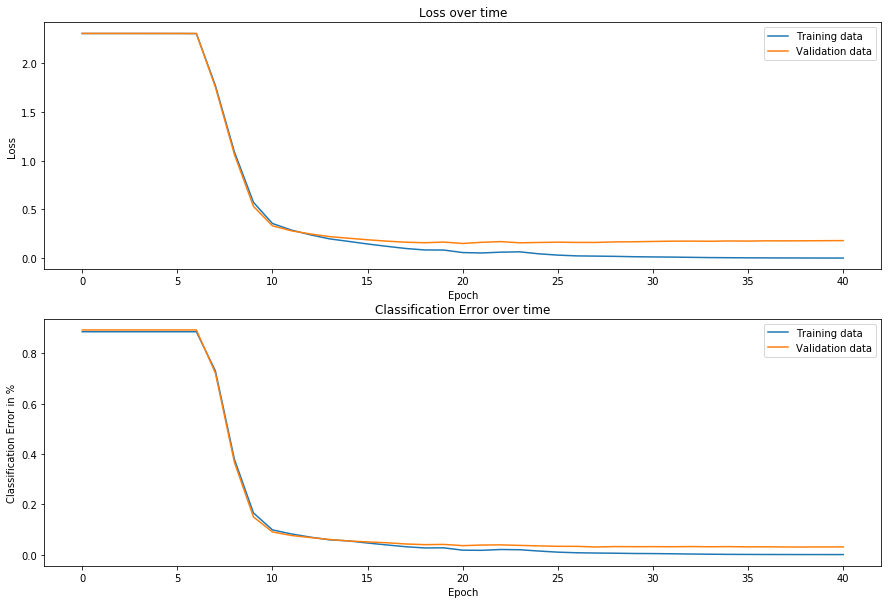

In [41]:
plot_training(train_results)